In [27]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.metrics import precision_score

In [42]:
def process_categorical_columns(df, exclude_cat_column):
    """
    Process categorical columns of a DataFrame by excluding and dropping a specified column,
    and converting the remaining categorical columns to ordinal encoding.

    Parameters:
    - df: Pandas DataFrame.
    - exclude_cat_column: Name of the column to be excluded from processing and dropped from DataFrame.

    Returns:
    - A DataFrame with processed categorical columns and without the excluded column.
    """
    # Create a copy of the DataFrame to avoid modifying the original DataFrame
    df = df.copy()

    # Select categorical columns (assuming object type for categorical data)
    categorical_cols = df.select_dtypes(include=['object']).columns

    # Exclude the specified column from the list of categorical columns to process
    categorical_cols = [col for col in categorical_cols if col != exclude_cat_column]

    # For each categorical column
    for col in categorical_cols:
        # Get the unique categories and sort them
        categories = df[col].unique()
        categories.sort()
        # Create a mapping from category to ordinal number
        mapping = {category: idx for idx, category in enumerate(categories)}
        # Apply the mapping
        df[col] = df[col].map(mapping)
    
    # Drop the excluded column from the DataFrame
    df.drop(columns=[exclude_cat_column], inplace=True)
    
    return df

def calculate_ppv_by_group(y_true, y_pred, groups):
    """
    Calculate the Positive Predictive Value (PPV) for each class and group.

    Parameters:
    - y_true: array-like, true labels
    - y_pred: array-like, predicted labels
    - groups: array-like, group membership for the protected attribute

    Returns:
    - ppvs: Dictionary holding the PPV for each class and group
    """
    classes = np.unique(y_true)  # Unique classes in your target
    unique_groups = np.unique(groups)  # Unique groups in your protected attribute

    # Dictionary to hold PPV for each class and group
    ppvs = {g: {c: None for c in classes} for g in unique_groups}

    for c in classes:
        for g in unique_groups:
            # Indices for the current group
            group_indices = np.where(groups == g)
            # Binarize y_true and y_pred for the current class
            y_true_binarized = (np.array(y_true)[group_indices] == c).astype(int)
            y_pred_binarized = (np.array(y_pred)[group_indices] == c).astype(int)

            # Calculate precision for the current class and group
            precision = precision_score(y_true_binarized, y_pred_binarized, pos_label=1, zero_division=0)
            ppvs[g][c] = round(precision, 3)

    return ppvs


def statistical_parity(data, target, protected_attribute):
    """
    Calculate the Statistical Parity for each class across different groups defined by a protected attribute.

    Parameters:
    - data: DataFrame containing the target labels and the protected attribute.
    - target: string, the name of the column containing the target class labels.
    - protected_attribute: string, the name of the column containing the protected attribute.

    Returns:
    - stat_parity: DataFrame showing the proportion of each class for each group in the protected attribute.
    """
    # Calculate the overall proportions of each class in the target
    overall_proportions = data[target].value_counts(normalize=True)
    
    # Group data by protected attribute and calculate proportions within each group
    group_proportions = data.groupby(protected_attribute)[target].value_counts(normalize=True).unstack(fill_value=0)
    
    # Calculate the differences from the overall proportions to assess disparity
    disparity = group_proportions - overall_proportions
    
    return disparity



def calculate_equalized_odds_differences(y_true, y_pred, groups):
    """
    Calculate and compare the True Positive Rate (TPR) and False Positive Rate (FPR) for each class across different groups defined by a protected attribute. This function identifies the differences to assess Equalized Odds.

    Parameters:
    - y_true: array-like, true labels
    - y_pred: array-like, predicted labels
    - groups: array-like, group membership for the protected attribute

    Returns:
    - comparison_results: DataFrame with differences in TPR and FPR for each class between groups
    """
    # Unique classes and groups
    classes = np.unique(y_true)
    unique_groups = np.unique(groups)
    
    # DataFrame to store TPR and FPR for each class and group
    metrics = pd.DataFrame()

    for group in unique_groups:
        for class_val in classes:
            # Create mask for the current group and class
            group_mask = (groups == group)
            class_mask_true = (y_true == class_val)
            class_mask_pred = (y_pred == class_val)
            
            # Confusion matrix for current class and group
            cm = confusion_matrix(class_mask_true[group_mask], class_mask_pred[group_mask])
            
            # Calculate TPR and FPR
            if cm.shape == (2, 2):  # Typical binary confusion matrix shape
                TN, FP, FN, TP = cm.ravel()
                TPR = TP / (TP + FN) if TP + FN > 0 else 0
                FPR = FP / (FP + TN) if FP + TN > 0 else 0
            else:
                TPR = 0
                FPR = 0
            
            # Append results
            metrics = pd.concat([metrics, pd.DataFrame({
                'Group': [group],
                'Class': [class_val],
                'TPR': [TPR],
                'FPR': [FPR]
            })], ignore_index=True)

    # Calculate differences in TPR and FPR between groups for each class
    comparison_results = pd.DataFrame()
    for class_val in classes:
        class_data = metrics[metrics['Class'] == class_val]
        if len(unique_groups) > 1:
            for i in range(len(unique_groups)):
                for j in range(i + 1, len(unique_groups)):
                    group1 = unique_groups[i]
                    group2 = unique_groups[j]
                    tpr_diff = abs(class_data[class_data['Group'] == group1]['TPR'].values[0] - class_data[class_data['Group'] == group2]['TPR'].values[0])
                    fpr_diff = abs(class_data[class_data['Group'] == group1]['FPR'].values[0] - class_data[class_data['Group'] == group2]['FPR'].values[0])
                    comparison_results = pd.concat([comparison_results, pd.DataFrame({
                        'Class': [class_val],
                        'Group1': [group1],
                        'Group2': [group2],
                        'TPR Difference': [tpr_diff],
                        'FPR Difference': [fpr_diff]
                    })], ignore_index=True)

    return comparison_results

def calculate_equal_opportunity_differences(y_true, y_pred, groups):
    """
    Calculate and compare the True Positive Rate (TPR) for each class across different groups defined by a protected attribute. This function identifies the differences to assess Equal Opportunity.

    Parameters:
    - y_true: array-like, true labels
    - y_pred: array-like, predicted labels
    - groups: array-like, group membership for the protected attribute

    Returns:
    - comparison_results: DataFrame with differences in TPR for each class between groups
    """
    # Unique classes and groups
    classes = np.unique(y_true)
    unique_groups = np.unique(groups)
    
    # DataFrame to store TPR for each class and group
    metrics = pd.DataFrame()

    for group in unique_groups:
        for class_val in classes:
            # Create mask for the current group and class
            group_mask = (groups == group)
            class_mask_true = (y_true == class_val)
            class_mask_pred = (y_pred == class_val)
            
            # Confusion matrix for current class and group
            cm = confusion_matrix(class_mask_true[group_mask], class_mask_pred[group_mask])
            
            # Calculate TPR (True Positive Rate)
            if cm.shape == (2, 2):  # Typical binary confusion matrix shape
                TN, FP, FN, TP = cm.ravel()
                TPR = TP / (TP + FN) if TP + FN > 0 else 0
            else:
                TPR = 0
            
            # Append results
            metrics = pd.concat([metrics, pd.DataFrame({
                'Group': [group],
                'Class': [class_val],
                'TPR': [TPR]
            })], ignore_index=True)

    # Calculate differences in TPR between groups for each class
    comparison_results = pd.DataFrame()
    for class_val in classes:
        class_data = metrics[metrics['Class'] == class_val]
        if len(unique_groups) > 1:
            for i in range(len(unique_groups)):
                for j in range(i + 1, len(unique_groups)):
                    group1 = unique_groups[i]
                    group2 = unique_groups[j]
                    tpr_diff = abs(class_data[class_data['Group'] == group1]['TPR'].values[0] - class_data[class_data['Group'] == group2]['TPR'].values[0])
                    comparison_results = pd.concat([comparison_results, pd.DataFrame({
                        'Class': [class_val],
                        'Group1': [group1],
                        'Group2': [group2],
                        'TPR Difference': [tpr_diff]
                    })], ignore_index=True)

    return comparison_results

def fairness_result_function(y_test, y_predict_rf ):
    df_test = y_test.to_frame().copy()    
    df_test['predict'] = y_predict_rf
    cat = pd.concat([X, df_test], axis=1).dropna()
    # cat

    y_true = cat["PerformanceRating"]  # True performance ratings
    y_pred = cat["predict"]  # Predicted performance ratings
    groups_gender = cat["Gender"]  # Protected attribute, gender
    groups_age = cat['Age']  # Protected attribute, age

    # PPV by Gender and Age
    ppvs_gender = calculate_ppv_by_group(y_true, y_pred, groups_gender)
    ppvs_age = calculate_ppv_by_group(y_true, y_pred, groups_age)

    # Statistical Parity Differences
    gender_parity_differences = statistical_parity(cat, "predict", "Gender")
    age_parity_differences = statistical_parity(cat, "predict", "Age")

    # Equalized Odds Differences
    gender_equalized_odd = calculate_equalized_odds_differences(y_true, y_pred, groups_gender)
    age_equalized_odd = calculate_equalized_odds_differences(y_true, y_pred, groups_age)

    # Equal Opportunity Differences
    gender_equal_opportunity = calculate_equal_opportunity_differences(y_true, y_pred, groups_gender)
    age_equal_opportunity = calculate_equal_opportunity_differences(y_true, y_pred, groups_age)

    print("Fairness Metrics Results:")
    print(f"PPVs by Gender:\n{ppvs_gender}")
    print(f"PPVs by Age:\n{ppvs_age}")
    print(f"Gender Parity Differences:\n{gender_parity_differences}")
    print(f"Age Parity Differences:\n{age_parity_differences}")
    print(f"Gender Equalized Odds Differences:\n{gender_equalized_odd}")
    print(f"Age Equalized Odds Differences:\n{age_equalized_odd}")
    print(f"Gender Equal Opportunity Differences:\n{gender_equal_opportunity}")
    print(f"Age Equal Opportunity Differences:\n{age_equal_opportunity}")

def grid_kmean_rf(X, y):
    # Scale the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Determine the best number of clusters using silhouette score
    best_silhouette_score = -1
    best_n_clusters = 0
    for n_clusters in range(2, 11):  # Cluster range from 2 to 10
        kmeans = KMeans(n_clusters=n_clusters, random_state=4, n_init=10)
        clusters = kmeans.fit_predict(X_scaled)
        silhouette_avg = silhouette_score(X_scaled, clusters)
        if silhouette_avg > best_silhouette_score:
            best_silhouette_score = silhouette_avg
            best_n_clusters = n_clusters
    print(f"The best number of clusters is {best_n_clusters} with a silhouette score of {best_silhouette_score}")

    # Clustering with the best number of clusters
    kmeans = KMeans(n_clusters=best_n_clusters, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(X_scaled)

    # Add the cluster labels as a new feature
    X_with_clusters = np.hstack((X, clusters.reshape(-1, 1)))

    # PCA for visualization
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(X_scaled)
    plt.figure(figsize=(10, 7))
    for i in range(best_n_clusters):
        plt.scatter(reduced_data[clusters == i, 0], reduced_data[clusters == i, 1], label=f'Cluster {i}')
    plt.legend()
    plt.title('Clusters visualization with PCA')
    plt.xlabel('PCA1')
    plt.ylabel('PCA2')
    plt.show()

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_with_clusters, y, test_size=0.3, random_state=42)

    # Random Forest with GridSearchCV
    classifier_rfg = RandomForestClassifier(random_state=42, n_estimators=100)
    parameters = [{'min_samples_split': [2, 3, 4, 5], 'criterion': ['gini', 'entropy'], 'min_samples_leaf': [1, 2, 3]}]
    model_gridrf = GridSearchCV(estimator=classifier_rfg, param_grid=parameters, scoring='accuracy', cv=10)
    model_gridrf.fit(X_train, y_train)
    best_model = model_gridrf.best_estimator_


    # Now, you can access feature_importances_ from this model
    feature_importances = best_model.feature_importances_
    # If X_train is indeed a DataFrame, you can get the feature names directly:
    feature_names = X.columns
    # Store feature importances and names in a list and sort them by importance
    importance_name_pairs = sorted(zip(feature_importances, feature_names), reverse=True)
    # Display the top 5 most important features
    print("Top 5 Most Important Features:")
    for name, importance in importance_name_pairs[:5]:
        print(name,importance)


    # Model evaluation
    y_predict_rf = model_gridrf.predict(X_test)
    accuracy = accuracy_score(y_test, y_predict_rf)
    print(f'Accuracy: {accuracy:.3f}')
    print(classification_report(y_test, y_predict_rf))

    return best_model, accuracy, y_test, y_predict_rf

def random_forest_wo_kmean(X, y):
    # Splitting the dataset into the Training set and Test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Initializing the classifier
    classifier_rfg = RandomForestClassifier(random_state=42, n_estimators=100)
    
    # Setting up the parameters for GridSearchCV
    parameters = [{'min_samples_split': [2, 3, 4, 5],
                   'criterion': ['gini', 'entropy'],
                   'min_samples_leaf': [1, 2, 3]}]
    
    # Creating the GridSearchCV object
    model_gridrf = GridSearchCV(estimator=classifier_rfg, param_grid=parameters, scoring='accuracy', cv=10)
    
    # Fitting the model with the training data
    model_gridrf.fit(X_train, y_train)
    
    # Predicting the test set results
    y_predict_rf = model_gridrf.predict(X_test)
    
    # Evaluating the results
    accuracy = accuracy_score(y_test, y_predict_rf)
    print(f'Accuracy: {accuracy:.3f}')
    print(classification_report(y_test, y_predict_rf))
    
    return y_test, y_predict_rf



In [43]:
df = pd.read_csv("resampled_dataset_gsmote.csv")
df.head()

,EducationBackground,MaritalStatus,EmpDepartment,EmpJobRole,BusinessTravelFrequency,DistanceFromHome,EmpEducationLevel,EmpEnvironmentSatisfaction,EmpHourlyRate,EmpJobInvolvement,...,TrainingTimesLastYear,EmpWorkLifeBalance,ExperienceYearsAtThisCompany,ExperienceYearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition,PerformanceRating,Age,Gender
0,2,2,5,13,2,10,3,4,55,3,...,2,2,10,7,0,8,0,3,32,1
1,2,2,5,13,2,14,4,4,42,3,...,2,3,7,7,1,7,0,3,47,1
2,1,1,5,13,1,5,4,4,48,2,...,2,3,18,13,1,12,0,4,40,1
3,0,0,3,8,2,10,4,2,73,2,...,2,2,21,6,12,6,0,3,41,1
4,2,2,5,13,2,16,4,1,84,3,...,1,3,2,2,2,2,0,3,60,1


In [44]:
# Reorder columns to move 'Performace rating" to the last
cols = df.columns.tolist()  # Get a list of all column names
cols.append(cols.pop(cols.index('PerformanceRating')))  # Move 'A' to the end
df = df[cols]  # Reassign the column order

In [45]:
df

,EducationBackground,MaritalStatus,EmpDepartment,EmpJobRole,BusinessTravelFrequency,DistanceFromHome,EmpEducationLevel,EmpEnvironmentSatisfaction,EmpHourlyRate,EmpJobInvolvement,...,TrainingTimesLastYear,EmpWorkLifeBalance,ExperienceYearsAtThisCompany,ExperienceYearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition,Age,Gender,PerformanceRating
0,2,2,5,13,2,10,3,4,55,3,...,2,2,10,7,0,8,0,32,1,3
1,2,2,5,13,2,14,4,4,42,3,...,2,3,7,7,1,7,0,47,1,3
2,1,1,5,13,1,5,4,4,48,2,...,2,3,18,13,1,12,0,40,1,4
3,0,0,3,8,2,10,4,2,73,2,...,2,2,21,6,12,6,0,41,1,3
4,2,2,5,13,2,16,4,1,84,3,...,1,3,2,2,2,2,0,60,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3231,2,0,5,13,1,4,2,1,42,2,...,2,2,9,1,0,8,0,28,1,3
3232,1,2,1,0,1,8,4,1,52,1,...,2,2,3,1,0,2,0,51,1,3
3233,4,1,1,3,2,2,1,3,100,2,...,2,3,2,1,1,0,0,22,1,3
3234,4,0,4,12,1,17,3,3,37,2,...,3,2,1,0,0,0,0,43,1,3


### Initate age to 2 groups

In [46]:
# Define bins for age ranges
bins = [17, 39, 60]  # Age bins for '18-39' and '40-60'
labels = ['18-39', '40-60']  # Corresponding labels for the bins

# Mapping of age range labels to numeric codes
label_to_code = {'18-39': 0, '40-60': 1}

# Apply binning, labeling, and mapping directly to the 'Age' column
df['Age'] = pd.cut(df['Age'], bins=bins, labels=labels, right=True).map(label_to_code)

df

,EducationBackground,MaritalStatus,EmpDepartment,EmpJobRole,BusinessTravelFrequency,DistanceFromHome,EmpEducationLevel,EmpEnvironmentSatisfaction,EmpHourlyRate,EmpJobInvolvement,...,TrainingTimesLastYear,EmpWorkLifeBalance,ExperienceYearsAtThisCompany,ExperienceYearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition,Age,Gender,PerformanceRating
0,2,2,5,13,2,10,3,4,55,3,...,2,2,10,7,0,8,0,0,1,3
1,2,2,5,13,2,14,4,4,42,3,...,2,3,7,7,1,7,0,1,1,3
2,1,1,5,13,1,5,4,4,48,2,...,2,3,18,13,1,12,0,1,1,4
3,0,0,3,8,2,10,4,2,73,2,...,2,2,21,6,12,6,0,1,1,3
4,2,2,5,13,2,16,4,1,84,3,...,1,3,2,2,2,2,0,1,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3231,2,0,5,13,1,4,2,1,42,2,...,2,2,9,1,0,8,0,0,1,3
3232,1,2,1,0,1,8,4,1,52,1,...,2,2,3,1,0,2,0,1,1,3
3233,4,1,1,3,2,2,1,3,100,2,...,2,3,2,1,1,0,0,0,1,3
3234,4,0,4,12,1,17,3,3,37,2,...,3,2,1,0,0,0,0,1,1,3


In [47]:
X = df.iloc[:,0:-1]
y = df.iloc[:,-1]

### 1. Random forest without K-mean

In [48]:
y_test, y_predict_rf = random_forest_wo_kmean(X, y)

Accuracy: 0.939
              precision    recall  f1-score   support

           2       0.96      0.91      0.93       253
           3       0.93      0.98      0.96       659
           4       0.90      0.61      0.73        59

    accuracy                           0.94       971
   macro avg       0.93      0.83      0.87       971
weighted avg       0.94      0.94      0.94       971



In [49]:
# Example of how to call the function
results = fairness_result_function(y_test, y_predict_rf)

Fairness Metrics Results:
PPVs by Gender:
{0: {2.0: 0.959, 3.0: 0.934, 4.0: 0.857}, 1: {2.0: 0.966, 3.0: 0.933, 4.0: 0.923}}
PPVs by Age:
{0: {2.0: 0.93, 3.0: 0.934, 4.0: 0.889}, 1: {2.0: 0.98, 3.0: 0.932, 4.0: 0.909}}
Gender Parity Differences:
predict       2.0       3.0       4.0
Gender                               
0        0.014455 -0.002922 -0.011534
1       -0.013673  0.002764  0.010910
Age Parity Differences:
predict       2.0       3.0       4.0
Age                                  
0       -0.074138  0.079333 -0.005195
1        0.078703 -0.084217  0.005514
Gender Equalized Odds Differences:
   Class  Group1  Group2  TPR Difference  FPR Difference
0    2.0       0       1        0.060579        0.004267
1    3.0       0       1        0.004176        0.005263
2    4.0       0       1        0.081301        0.000038
Age Equalized Odds Differences:
   Class  Group1  Group2  TPR Difference  FPR Difference
0    2.0       0       1        0.062112        0.005028
1    3.0       0 

/var/folders/gl/0z6xncpj2xjdv24r5kmz1mtc0000gp/T/ipykernel_19191/2876934355.py:86: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_proportions = data.groupby(protected_attribute)[target].value_counts(normalize=True).unstack(fill_value=0)


#### 2. Random forest with k-mean

The best number of clusters is 2 with a silhouette score of 0.12569929889586065


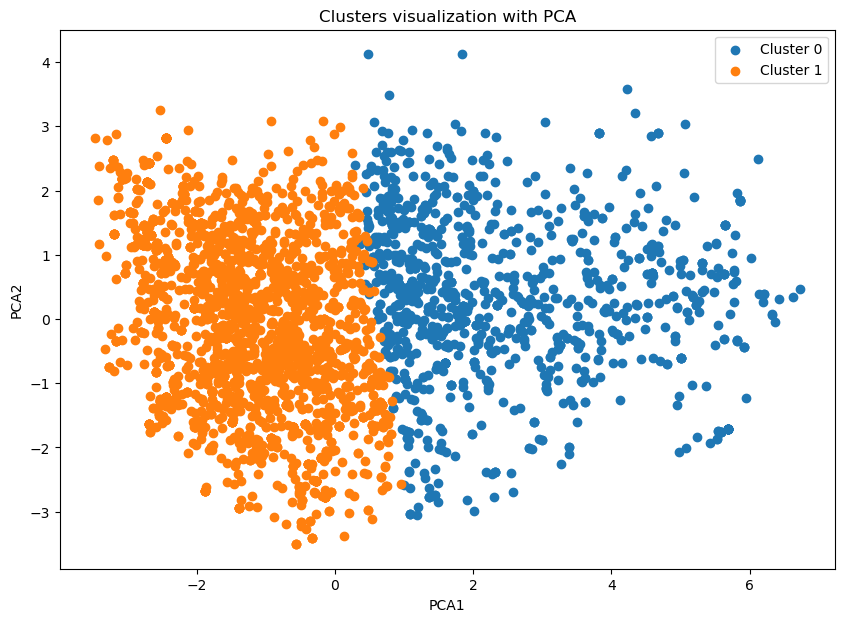

Top 5 Most Important Features:
0.13973170582500463 EmpLastSalaryHikePercent
0.13681752432133612 EmpEnvironmentSatisfaction
0.07365542670625332 YearsSinceLastPromotion
0.06748721889543113 EmpHourlyRate
0.05073692152891022 ExperienceYearsInCurrentRole
Accuracy: 0.938
              precision    recall  f1-score   support

           2       0.96      0.91      0.93       253
           3       0.93      0.98      0.96       659
           4       0.90      0.61      0.73        59

    accuracy                           0.94       971
   macro avg       0.93      0.83      0.87       971
weighted avg       0.94      0.94      0.94       971



In [50]:
best_model, model_accuracy, y_test, y_ = grid_kmean_rf(X, y)

In [52]:
results = fairness_result_function(y_test, y_predict_rf)

Fairness Metrics Results:
PPVs by Gender:
{0: {2.0: 0.959, 3.0: 0.934, 4.0: 0.857}, 1: {2.0: 0.966, 3.0: 0.933, 4.0: 0.923}}
PPVs by Age:
{0: {2.0: 0.93, 3.0: 0.934, 4.0: 0.889}, 1: {2.0: 0.98, 3.0: 0.932, 4.0: 0.909}}
Gender Parity Differences:
predict       2.0       3.0       4.0
Gender                               
0        0.014455 -0.002922 -0.011534
1       -0.013673  0.002764  0.010910
Age Parity Differences:
predict       2.0       3.0       4.0
Age                                  
0       -0.074138  0.079333 -0.005195
1        0.078703 -0.084217  0.005514
Gender Equalized Odds Differences:
   Class  Group1  Group2  TPR Difference  FPR Difference
0    2.0       0       1        0.060579        0.004267
1    3.0       0       1        0.004176        0.005263
2    4.0       0       1        0.081301        0.000038
Age Equalized Odds Differences:
   Class  Group1  Group2  TPR Difference  FPR Difference
0    2.0       0       1        0.062112        0.005028
1    3.0       0 

/var/folders/gl/0z6xncpj2xjdv24r5kmz1mtc0000gp/T/ipykernel_19191/2876934355.py:86: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_proportions = data.groupby(protected_attribute)[target].value_counts(normalize=True).unstack(fill_value=0)


#### 3. random forest with k-mean and dropping protected features
Fairness through unawareness (exclude all protected attributes) with K-mean clustering
conclude: more accurate and more fair

In [53]:
df

,EducationBackground,MaritalStatus,EmpDepartment,EmpJobRole,BusinessTravelFrequency,DistanceFromHome,EmpEducationLevel,EmpEnvironmentSatisfaction,EmpHourlyRate,EmpJobInvolvement,...,TrainingTimesLastYear,EmpWorkLifeBalance,ExperienceYearsAtThisCompany,ExperienceYearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition,Age,Gender,PerformanceRating
0,2,2,5,13,2,10,3,4,55,3,...,2,2,10,7,0,8,0,0,1,3
1,2,2,5,13,2,14,4,4,42,3,...,2,3,7,7,1,7,0,1,1,3
2,1,1,5,13,1,5,4,4,48,2,...,2,3,18,13,1,12,0,1,1,4
3,0,0,3,8,2,10,4,2,73,2,...,2,2,21,6,12,6,0,1,1,3
4,2,2,5,13,2,16,4,1,84,3,...,1,3,2,2,2,2,0,1,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3231,2,0,5,13,1,4,2,1,42,2,...,2,2,9,1,0,8,0,0,1,3
3232,1,2,1,0,1,8,4,1,52,1,...,2,2,3,1,0,2,0,1,1,3
3233,4,1,1,3,2,2,1,3,100,2,...,2,3,2,1,1,0,0,0,1,3
3234,4,0,4,12,1,17,3,3,37,2,...,3,2,1,0,0,0,0,1,1,3


In [54]:
# Drop multiple columns: 'Age' and 'City'
df_drop_protected_features = df.drop(['Age', 'Gender'], axis=1)

In [55]:
df_drop_protected_features

,EducationBackground,MaritalStatus,EmpDepartment,EmpJobRole,BusinessTravelFrequency,DistanceFromHome,EmpEducationLevel,EmpEnvironmentSatisfaction,EmpHourlyRate,EmpJobInvolvement,...,EmpRelationshipSatisfaction,TotalWorkExperienceInYears,TrainingTimesLastYear,EmpWorkLifeBalance,ExperienceYearsAtThisCompany,ExperienceYearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition,PerformanceRating
0,2,2,5,13,2,10,3,4,55,3,...,4,10,2,2,10,7,0,8,0,3
1,2,2,5,13,2,14,4,4,42,3,...,4,20,2,3,7,7,1,7,0,3
2,1,1,5,13,1,5,4,4,48,2,...,3,20,2,3,18,13,1,12,0,4
3,0,0,3,8,2,10,4,2,73,2,...,2,23,2,2,21,6,12,6,0,3
4,2,2,5,13,2,16,4,1,84,3,...,4,10,1,3,2,2,2,2,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3231,2,0,5,13,1,4,2,1,42,2,...,2,9,2,2,9,1,0,8,0,3
3232,1,2,1,0,1,8,4,1,52,1,...,4,18,2,2,3,1,0,2,0,3
3233,4,1,1,3,2,2,1,3,100,2,...,2,3,2,3,2,1,1,0,0,3
3234,4,0,4,12,1,17,3,3,37,2,...,3,6,3,2,1,0,0,0,0,3


In [56]:
X_drop_protected_f = df_drop_protected_features.iloc[:,1:-1]
y = df_drop_protected_features.iloc[:,-1]

The best number of clusters is 2 with a silhouette score of 0.14047361487164944


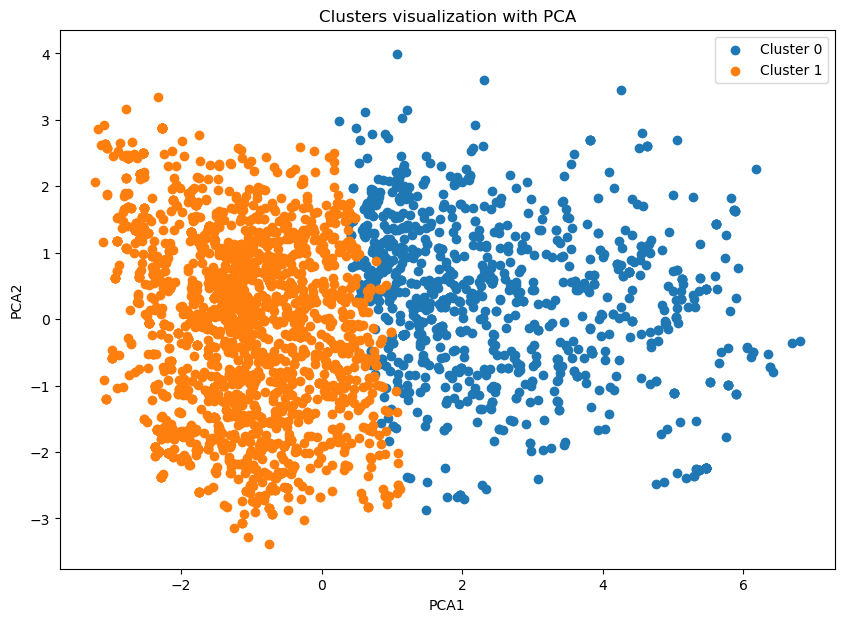

Top 5 Most Important Features:
0.14705277698747282 EmpEnvironmentSatisfaction
0.10968708396983137 EmpLastSalaryHikePercent
0.08201890946353714 EmpHourlyRate
0.08101636072772213 YearsSinceLastPromotion
0.05219674899044775 ExperienceYearsInCurrentRole
Accuracy: 0.939
              precision    recall  f1-score   support

           2       0.96      0.91      0.93       253
           3       0.93      0.98      0.96       659
           4       0.90      0.61      0.73        59

    accuracy                           0.94       971
   macro avg       0.93      0.83      0.87       971
weighted avg       0.94      0.94      0.94       971



In [57]:
best_model, accuracy, y_test, y_predict_rf = grid_kmean_rf(X_drop_protected_f, y)

In [58]:
results = fairness_result_function(y_test, y_predict_rf)

Fairness Metrics Results:
PPVs by Gender:
{0: {2.0: 0.959, 3.0: 0.934, 4.0: 0.857}, 1: {2.0: 0.966, 3.0: 0.933, 4.0: 0.923}}
PPVs by Age:
{0: {2.0: 0.94, 3.0: 0.932, 4.0: 0.889}, 1: {2.0: 0.974, 3.0: 0.935, 4.0: 0.909}}
Gender Parity Differences:
predict       2.0       3.0       4.0
Gender                               
0        0.014455 -0.002922 -0.011534
1       -0.013673  0.002764  0.010910
Age Parity Differences:
predict       2.0       3.0       4.0
Age                                  
0       -0.078138  0.083333 -0.005195
1        0.082949 -0.088464  0.005514
Gender Equalized Odds Differences:
   Class  Group1  Group2  TPR Difference  FPR Difference
0    2.0       0       1        0.060579        0.004267
1    3.0       0       1        0.004176        0.005263
2    4.0       0       1        0.081301        0.000038
Age Equalized Odds Differences:
   Class  Group1  Group2  TPR Difference  FPR Difference
0    2.0       0       1        0.079193        0.000648
1    3.0       0

/var/folders/gl/0z6xncpj2xjdv24r5kmz1mtc0000gp/T/ipykernel_19191/2876934355.py:86: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_proportions = data.groupby(protected_attribute)[target].value_counts(normalize=True).unstack(fill_value=0)


### 4. random forest without k-mean and dropping protected features

In [59]:
y_test, y_predict_rf = random_forest_wo_kmean(X_drop_protected_f, y)

Accuracy: 0.940
              precision    recall  f1-score   support

           2       0.95      0.92      0.94       253
           3       0.94      0.98      0.96       659
           4       0.90      0.63      0.74        59

    accuracy                           0.94       971
   macro avg       0.93      0.84      0.88       971
weighted avg       0.94      0.94      0.94       971



In [60]:
results_without_kmean = fairness_result_function(y_test, y_predict_rf)

Fairness Metrics Results:
PPVs by Gender:
{0: {2.0: 0.959, 3.0: 0.937, 4.0: 0.867}, 1: {2.0: 0.943, 3.0: 0.94, 4.0: 0.923}}
PPVs by Age:
{0: {2.0: 0.911, 3.0: 0.941, 4.0: 0.895}, 1: {2.0: 0.974, 3.0: 0.935, 4.0: 0.909}}
Gender Parity Differences:
predict       2.0       3.0       4.0
Gender                               
0        0.008276  0.002169 -0.010445
1       -0.007828 -0.002051  0.009880
Age Parity Differences:
predict       2.0       3.0       4.0
Age                                  
0       -0.072317  0.076542 -0.004225
1        0.076770 -0.081254  0.004485
Gender Equalized Odds Differences:
   Class  Group1  Group2  TPR Difference  FPR Difference
0    2.0       0       1        0.085790        0.003628
1    3.0       0       1        0.004674        0.006908
2    4.0       0       1        0.136856        0.000038
Age Equalized Odds Differences:
   Class  Group1  Group2  TPR Difference  FPR Difference
0    2.0       0       1        0.046584        0.006705
1    3.0       0

/var/folders/gl/0z6xncpj2xjdv24r5kmz1mtc0000gp/T/ipykernel_19191/2876934355.py:86: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_proportions = data.groupby(protected_attribute)[target].value_counts(normalize=True).unstack(fill_value=0)
